In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"


###########################################################################################
# EDITS FOR HOMEWORK PURPOSES MADE BY ALEC SCZEPANSKI                                     #
#                                                                                         #
# ATSC 528 ASSIGNMENT #1                                                                  #
###########################################################################################

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

import pandas as pd

In [3]:
### Read in observations ###

# Establish column names:
col_names = ['station', 'latitude',
             'longitude', 'height',
             'wind_dir', 'wind_spd']

# Read in data:
df = pd.read_csv('RAOBs_201903131200.txt',
                 names = col_names)

# Establish variables:
station_id = df['station']
latitude = df['latitude']
longitude = df['longitude']
height = df['height']
dd = df['wind_dir']
ff = df['wind_spd']

In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###

# Some constants:
dx = 1.27 #in cm
dy = 1.27 #in cm
x_0 = 18.9 #in cm; upper left corner
y_0 = -6.3 #in cm; upper left corner

# Set up x and y intervals for grid:
x_i = x_0 + (np.arange(22)*dx)
y_j = y_0 + (np.arange(28)*dy)

# Combine x_i and y_j into a grid:
x_grid, y_grid = np.meshgrid(x_i, y_j)

**Finding *r* to plug into equations for *x* and *y*:** <br>$r = \rho \sigma cos(\phi)$, where: 

- $\rho$ = radius of Earth = 6371 km = 6371000 m
- $\sigma = (1 + sin(\phi_O)) / (1 + sin(\phi))$
- $\phi_O$ = standard latitude 60
- $\phi$ = latitude

**Converting to x:** <br>$x = r cos(\lambda_O - \lambda)$

**Converting to y:** <br>$y = r sin(\lambda_O - \lambda)$, where:

- $\lambda_O$ = reference longitude = -115
- $\lambda$ = longitude deviation from standard longitude

In [5]:
# Convert observation lat and lon to x and y coordinates:
R = 637100000 #radius of Earth in centimeters
phi_O_rad = 60*(np.pi/180) #standard latitude in radians
lam_O = -115*(np.pi/180) #reference longitude in radians
m = 1/15000000 #map projection
lat_rad = latitude*(np.pi/180) #latitudes in radians
lon_rad = longitude*(np.pi/180) #Longitude in radians
sigma = (1 + np.sin(phi_O_rad))/(1 + np.sin(lat_rad))


# Calculate observation lat, lon in x, y coordinates:
r = m*(R*sigma*np.cos(lat_rad))
x_obs = r*(np.cos(lon_rad - lam_O))
y_obs = r*(np.sin(lon_rad - lam_O))

**Finding $\phi$ and $\lambda$ from *x* and *y*:**

$\phi = (\pi / 2)-2arctan[\sqrt{(x^2+y^2)} / \rho (1+sin(\phi_O))]$

$\lambda_O - \lambda = arctan(y/x)$

In [6]:
# Convert gridded points to phi and lambda (lat, lon):
phi_grid = (np.pi/2) - (2*(np.arctan(np.sqrt((x_grid / m)**2 + (y_grid / m)**2) / (R*(1 + np.sin(phi_O_rad))))))
phi_grid = phi_grid * (180/np.pi)
lam_grid = (lam_O + np.arctan(y_grid/x_grid)) * (180/np.pi)

# Convert observations to phi and lambda (lat, lon):
phi_obs = (np.pi/2) - (2*(np.arctan(np.sqrt((x_obs / m)**2 + (y_obs / m)**2) / (R*(1 + np.sin(phi_O_rad))))))
phi_obs = phi_obs * (180/np.pi)
lam_obs = (lam_O + np.arctan(y_obs/x_obs)) * (180/np.pi)

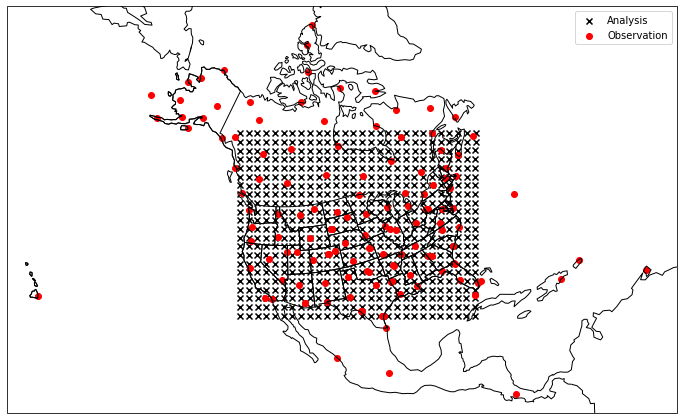

In [7]:
# Make a plot of the map:

# Make stereographic projection via cartopy:
projection = ccrs.Stereographic(central_longitude = -115, #set reference longitude to 115 W
                                central_latitude = 90, #project onto map with 90 N at center
                                true_scale_latitude = 60) #set 60 N as reference latitude

# Create figure:
fig = plt.figure(figsize = (12,12))

# Add axes:
ax = fig.add_subplot(111, projection = projection)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)

# Plot grid points:
plt.scatter(lam_grid, phi_grid, transform = ccrs.PlateCarree(), marker = 'x', color = 'black', label = 'Analysis')

# Plot observation locations:
plt.scatter(lam_obs, phi_obs, transform = ccrs.PlateCarree(), marker = 'o', color = 'red', label = 'Observation')

plt.legend(loc = 'upper right')

plt.show()

---
## **ROI = 10 cm:**

In [8]:
# Perform 500 mb geopotential height analyses using a second order 
# 2-D polynomial with two radii of influence: 10 and 20 cm

# Establish array to house analysis values for ROI = 10 cm:
ROI_ten = np.full((len(y_j), len(x_i)), -999.9)

# Same, but for ROI = 20 cm:
ROI_twenty = np.full((len(y_j), len(x_i)), -999.9)

# Establish an array to save number of obs in ROI per analysis point:
num_obs_ten = np.zeros((len(y_j), len(x_i)))

# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Establish ROI:
        ROI = 10 #cm
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        magnitude = (X_k**2 + Y_k**2)**(1/2)
        
        # Determine which indices fall within the ROI:
        indices = np.where(magnitude <= ROI)
        
        # Append the length of 'indices' to num_obs:
        num_obs_ten[i][j] = len(indices[0])
        
        # Create arrays of all x_k, y_k, and heights (f_O) in ROI:
        x_k = X_k[indices[0]].values
        y_k = Y_k[indices[0]].values
        f_O = height[indices[0]].values
        
        # Establish an array of zeroes as a beginning for the 'R' matrix
        # and another array of zeroes for the 'O' vector. 
        # 'R' matrix is 6x6, and 'O' vector is 1x6:
        R_matrix = np.zeros((6,6))
        O_vector = np.zeros(6)
        
        # Loop through the length of x_k calculating the parts of
        # R_matrix and O_vector:
        for k in range(len(x_k)):
            
            ### Start with R_matrix:
            
            # First element is the number 1:
            one = 1
            
            # Second element is x_k:
            x = x_k[k]
            
            # Third element is y_k:
            y = y_k[k]
            
            # Fourth element is x_k squared:
            xx = x**2
            
            # Fifth element is y_k squared:
            yy = y**2
            
            # Sixth and final element is x_k times y_k:
            xy = x*y
            
            # Put these elements into an array that acts as the first
            # row of R_matrix:
            R_row = np.array([[one,
                               x,
                               y,
                               xx,
                               yy,
                               xy]])
            
            # Transpose R_row and multiply it by R_row to get the R_matrix;
            # append to R_matrix established previously:
            R_matrix += ((np.transpose(R_row))*R_row)
        
            ### Next, O_vector:
            
            # O_vector is the product of R_matrix and a coefficient
            # vector, which will later be called C_vector.
            
            # First element is f_O:
            f = f_O[k]
            
            # Second element is x_k times f_O:
            xf = x*f
            
            # Third element is y_k times f_O:
            yf = y*f
            
            # Fourth element is x_k squared times f_O:
            xxf = xx*f
            
            # Fifth element is y_k squared times f_O:
            yyf = yy*f
            
            # Sixth and final element is x_h times y_h times f_O:
            xyf = xy*f
            
            # Put these elements into an array that will be appended to 
            # O_vector:
            O_vector += (np.array([f,
                                   xf,
                                   yf,
                                   xxf,
                                   yyf,
                                   xyf]))
            
        # Get the mean values of R_matrix and O_vector by dividing each
        # by num_obs array. Also, immediately convert these arrays to
        # proper matrices:
        R_matrix = np.matrix(R_matrix / num_obs_ten[i][j])
        
        O_vector = np.matrix(O_vector / num_obs_ten[i][j])
        
        # Calculate the 'C' vector by multiplying inverse of R_matrix
        # by O_vector [ RC = O --> C = (R^-1)O ]:
        C_vector = np.linalg.inv(R_matrix)*np.transpose(O_vector)
        C_vector = np.linalg.inv(R_matrix)*O_vector.T
        
        
        # Finally, take the first value from C_vector (C_00) and append
        # to ROI_ten:
        ROI_ten[i][j] = C_vector[0][0]

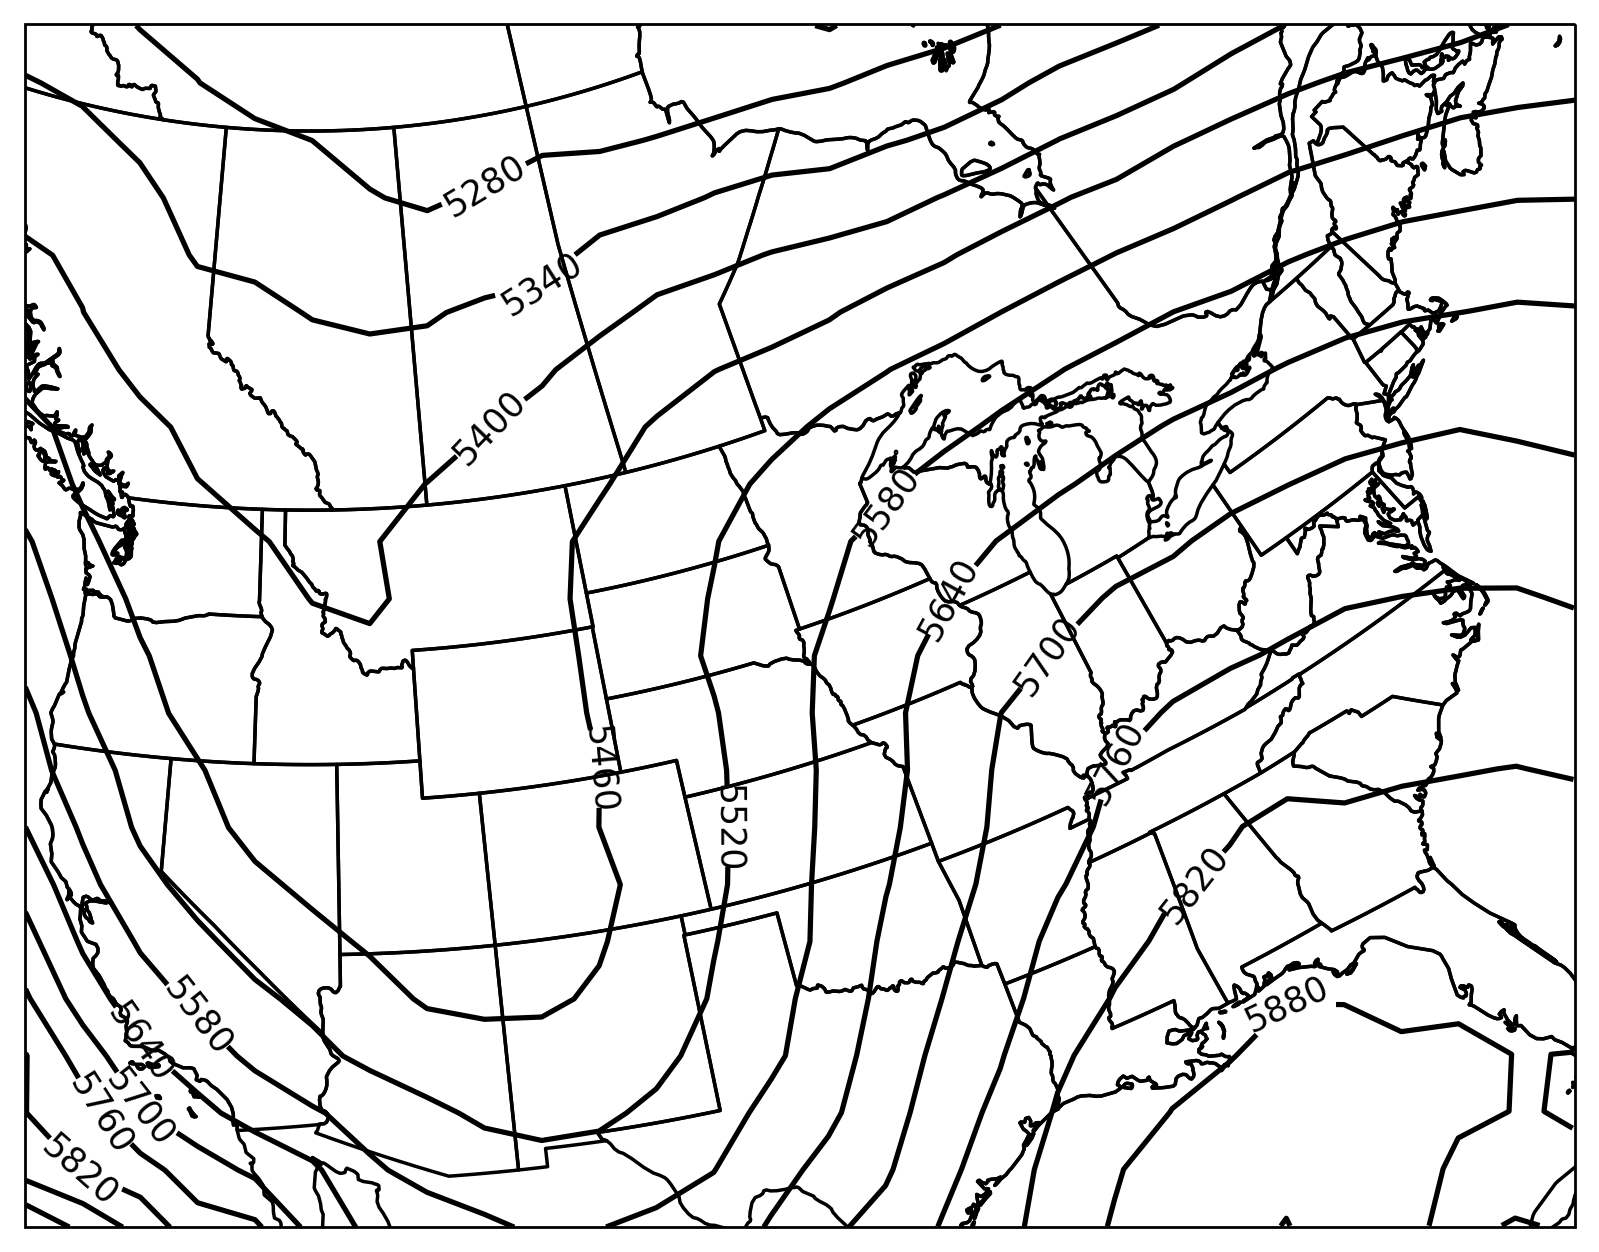

In [9]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,ROI_ten,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

plt.savefig('Sczepanski_ATSC528_HW1_500hts_ROI10.png', dpi = 250)
plt.show()

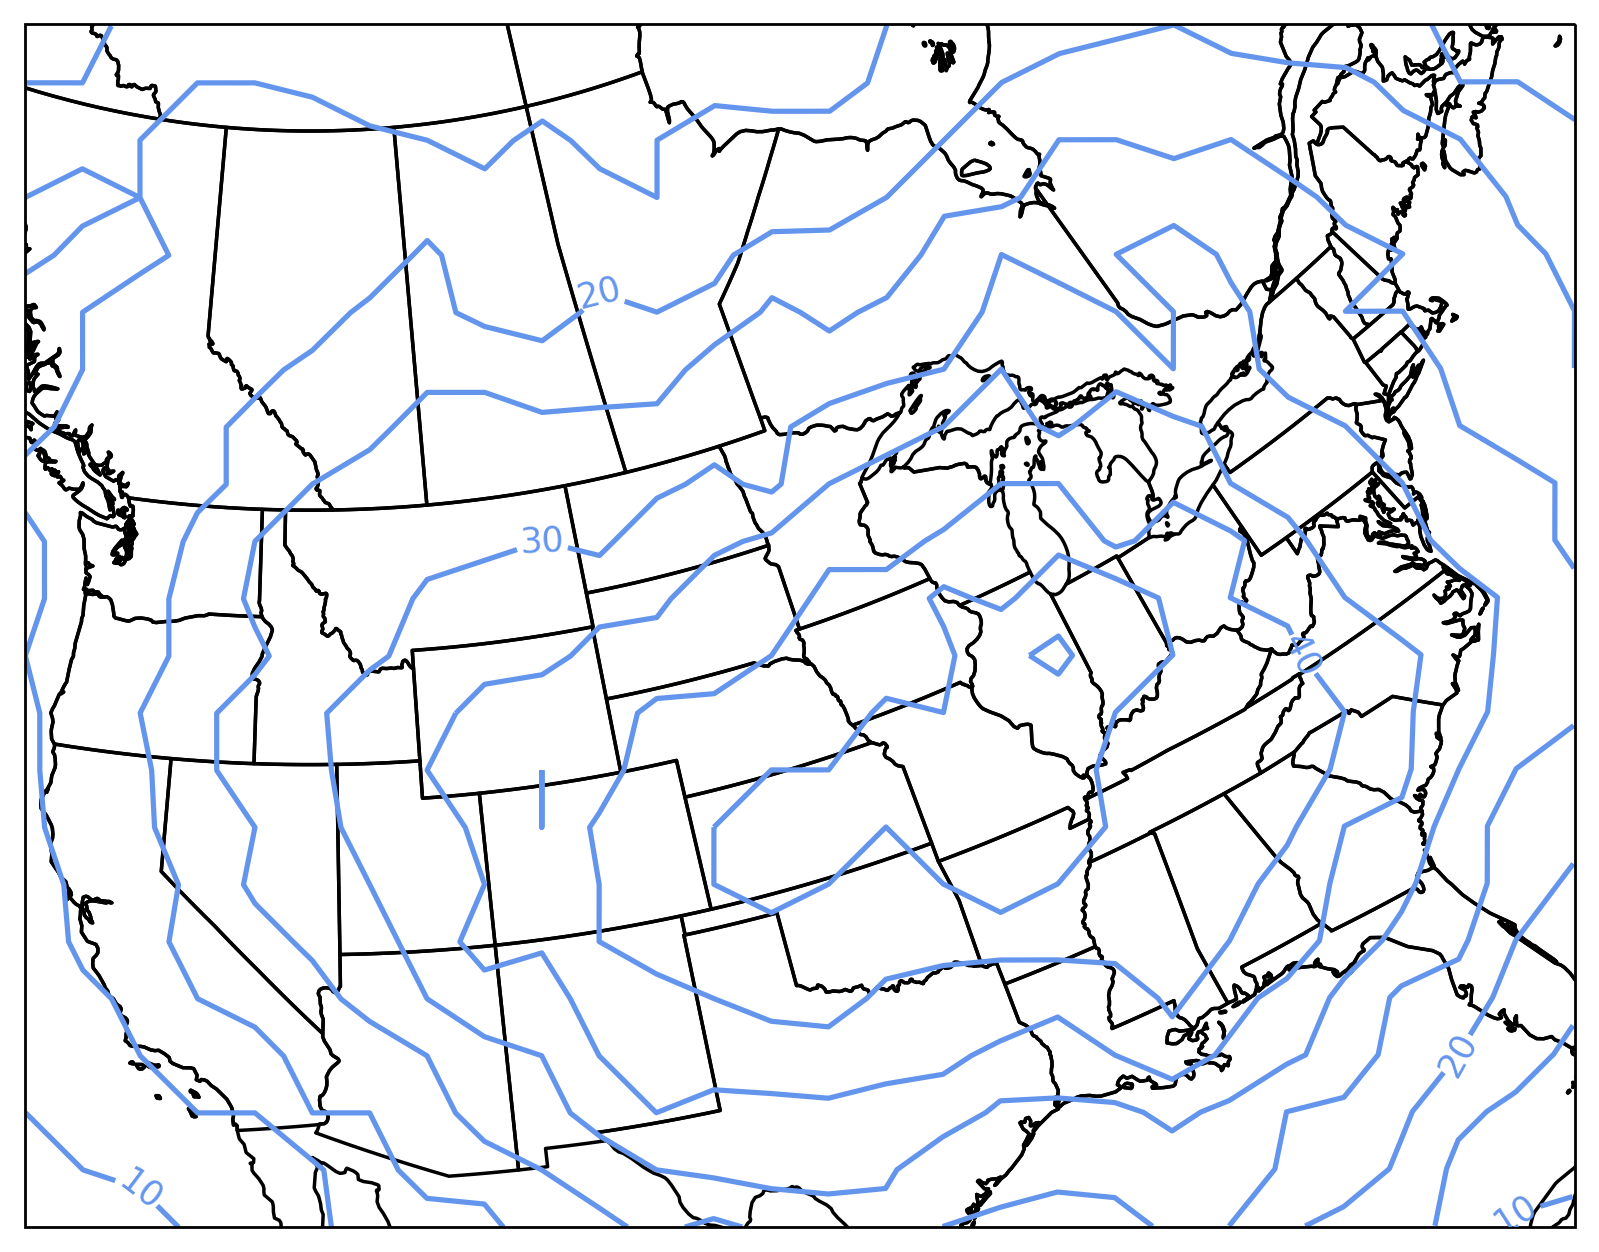

In [10]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,num_obs_ten,colors='cornflowerblue',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.savefig('Sczepanski_ATSC528_HW1_numobs_ROI10.png', dpi = 250)
plt.show()

---
## **ROI = 20 cm:**

In [11]:
# Now repeat for ROI = 20 cm:

# Establish an array to save number of obs in ROI per analysis point:
num_obs_twenty = np.zeros((len(y_j), len(x_i)))

# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Establish ROI:
        ROI = 20 #cm
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        magnitude = (X_k**2 + Y_k**2)**(1/2)
        
        # Determine which indices fall within the ROI:
        indices = np.where(magnitude <= ROI)
        
        # Append the length of 'indices' to num_obs:
        num_obs_twenty[i][j] = len(indices[0])
        
        # Create arrays of all x_k, y_k, and heights (f_O) in ROI:
        x_k = X_k[indices[0]].values
        y_k = Y_k[indices[0]].values
        f_O = height[indices[0]].values
        
        # Establish an array of zeroes as a beginning for the 'R' matrix
        # and another array of zeroes for the 'O' vector. 
        # 'R' matrix is 6x6, and 'O' vector is 1x6:
        R_matrix = np.zeros((6,6))
        O_vector = np.zeros(6)
        
        # Loop through the length of x_k calculating the parts of
        # R_matrix and O_vector:
        for k in range(len(x_k)):
            
            ### Start with R_matrix:
            
            # First element is the number 1:
            one = 1
            
            # Second element is x_k:
            x = x_k[k]
            
            # Third element is y_k:
            y = y_k[k]
            
            # Fourth element is x_k squared:
            xx = x**2
            
            # Fifth element is y_k squared:
            yy = y**2
            
            # Sixth and final element is x_k times y_k:
            xy = x*y
            
            # Put these elements into an array that acts as the first
            # row of R_matrix:
            R_row = np.array([[one,
                               x,
                               y,
                               xx,
                               yy,
                               xy]])
            
            # Transpose R_row and multiply it by R_row to get the R_matrix;
            # append to R_matrix established previously:
            R_matrix += ((np.transpose(R_row))*R_row)
        
            ### Next, O_vector:
            
            # O_vector is the product of R_matrix and a coefficient
            # vector, which will later be called C_vector.
            
            # First element is f_O:
            f = f_O[k]
            
            # Second element is x_k times f_O:
            xf = x*f
            
            # Third element is y_k times f_O:
            yf = y*f
            
            # Fourth element is x_k squared times f_O:
            xxf = xx*f
            
            # Fifth element is y_k squared times f_O:
            yyf = yy*f
            
            # Sixth and final element is x_h times y_h times f_O:
            xyf = xy*f
            
            # Put these elements into an array that will be appended to 
            # O_vector:
            O_vector += (np.array([f,
                                   xf,
                                   yf,
                                   xxf,
                                   yyf,
                                   xyf]))
            
        # Get the mean values of R_matrix and O_vector by dividing each
        # by num_obs array. Also, immediately convert these arrays to
        # proper matrices:
        R_matrix = np.matrix(R_matrix / num_obs_twenty[i][j])
        
        O_vector = np.matrix(O_vector / num_obs_twenty[i][j])
        
        # Calculate the 'C' vector by multiplying inverse of R_matrix
        # by O_vector [ RC = O --> C = (R^-1)O ]:
        C_vector = np.linalg.inv(R_matrix)*np.transpose(O_vector)
        
        # Finally, take the first value from C_vector (C_00) and append
        # to ROI_ten:
        ROI_twenty[i][j] = C_vector[0][0]

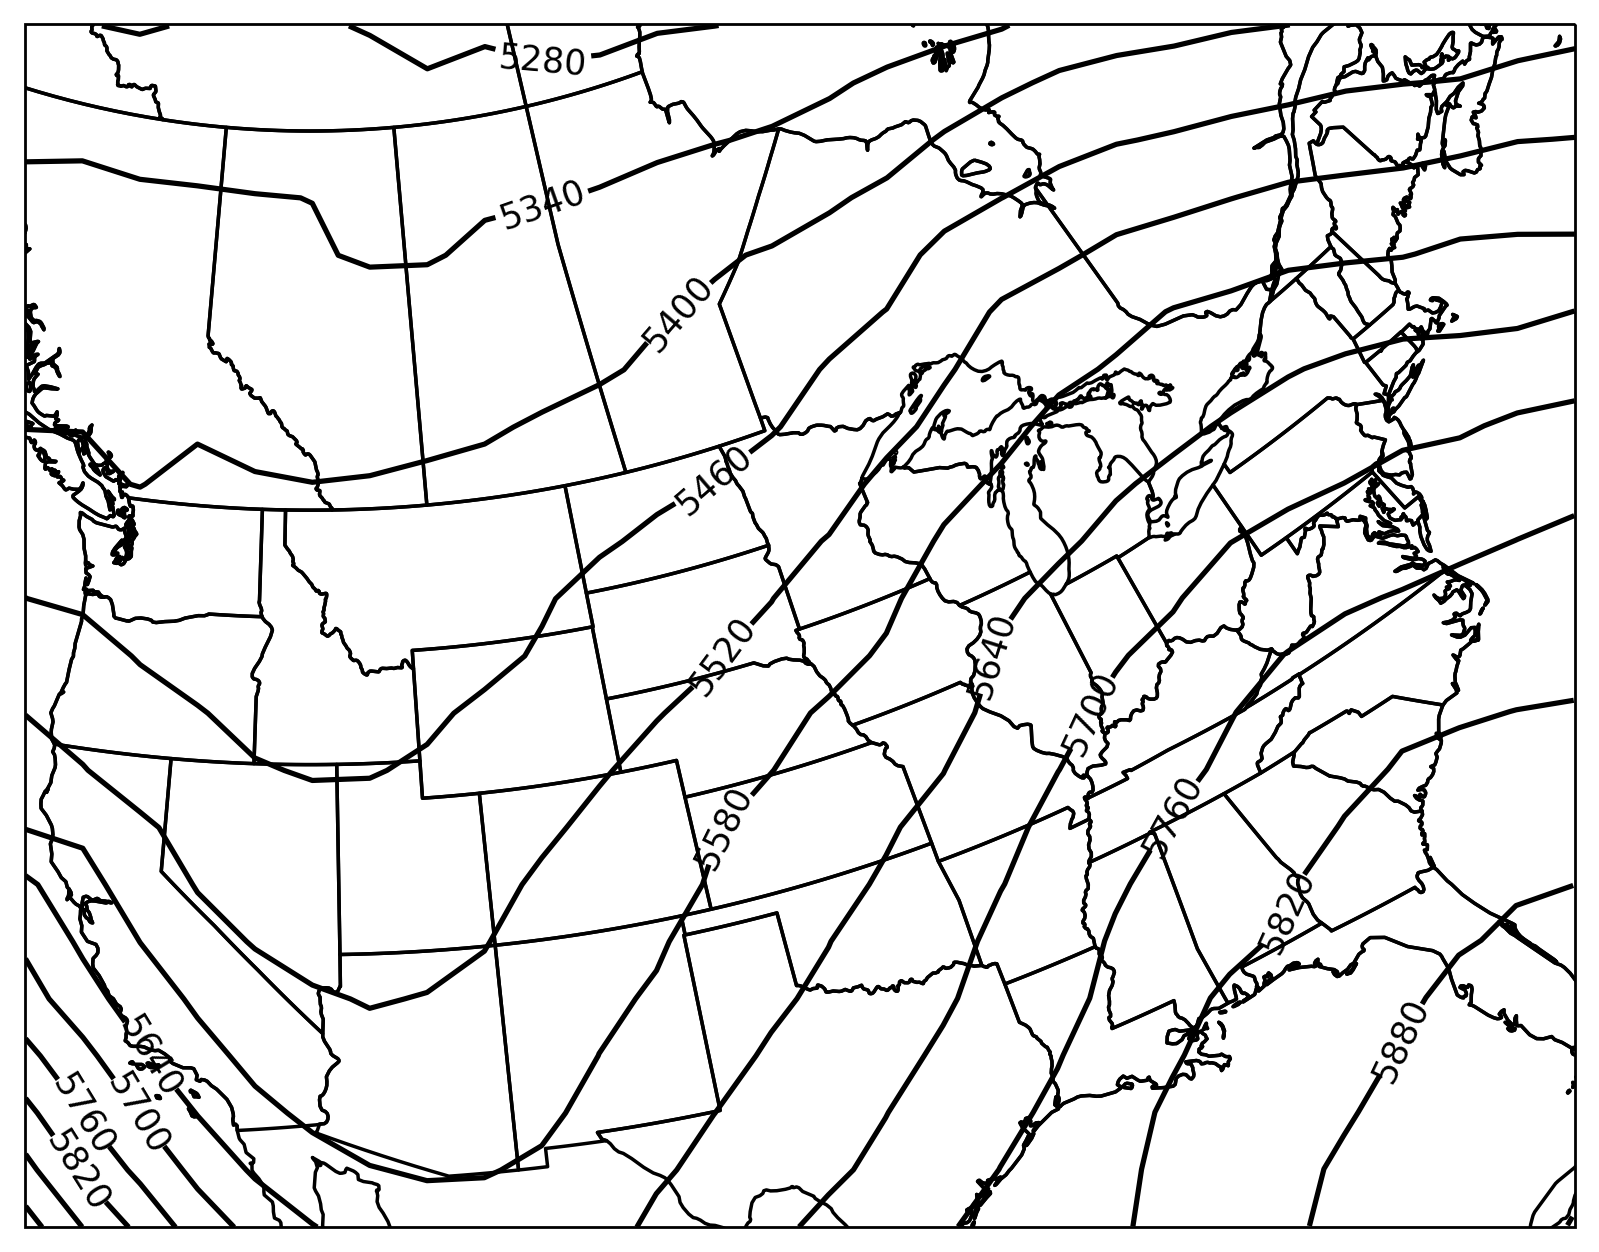

In [12]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,ROI_twenty,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

plt.savefig('Sczepanski_ATSC528_HW1_500hts_ROI20.png', dpi = 250)
plt.show()

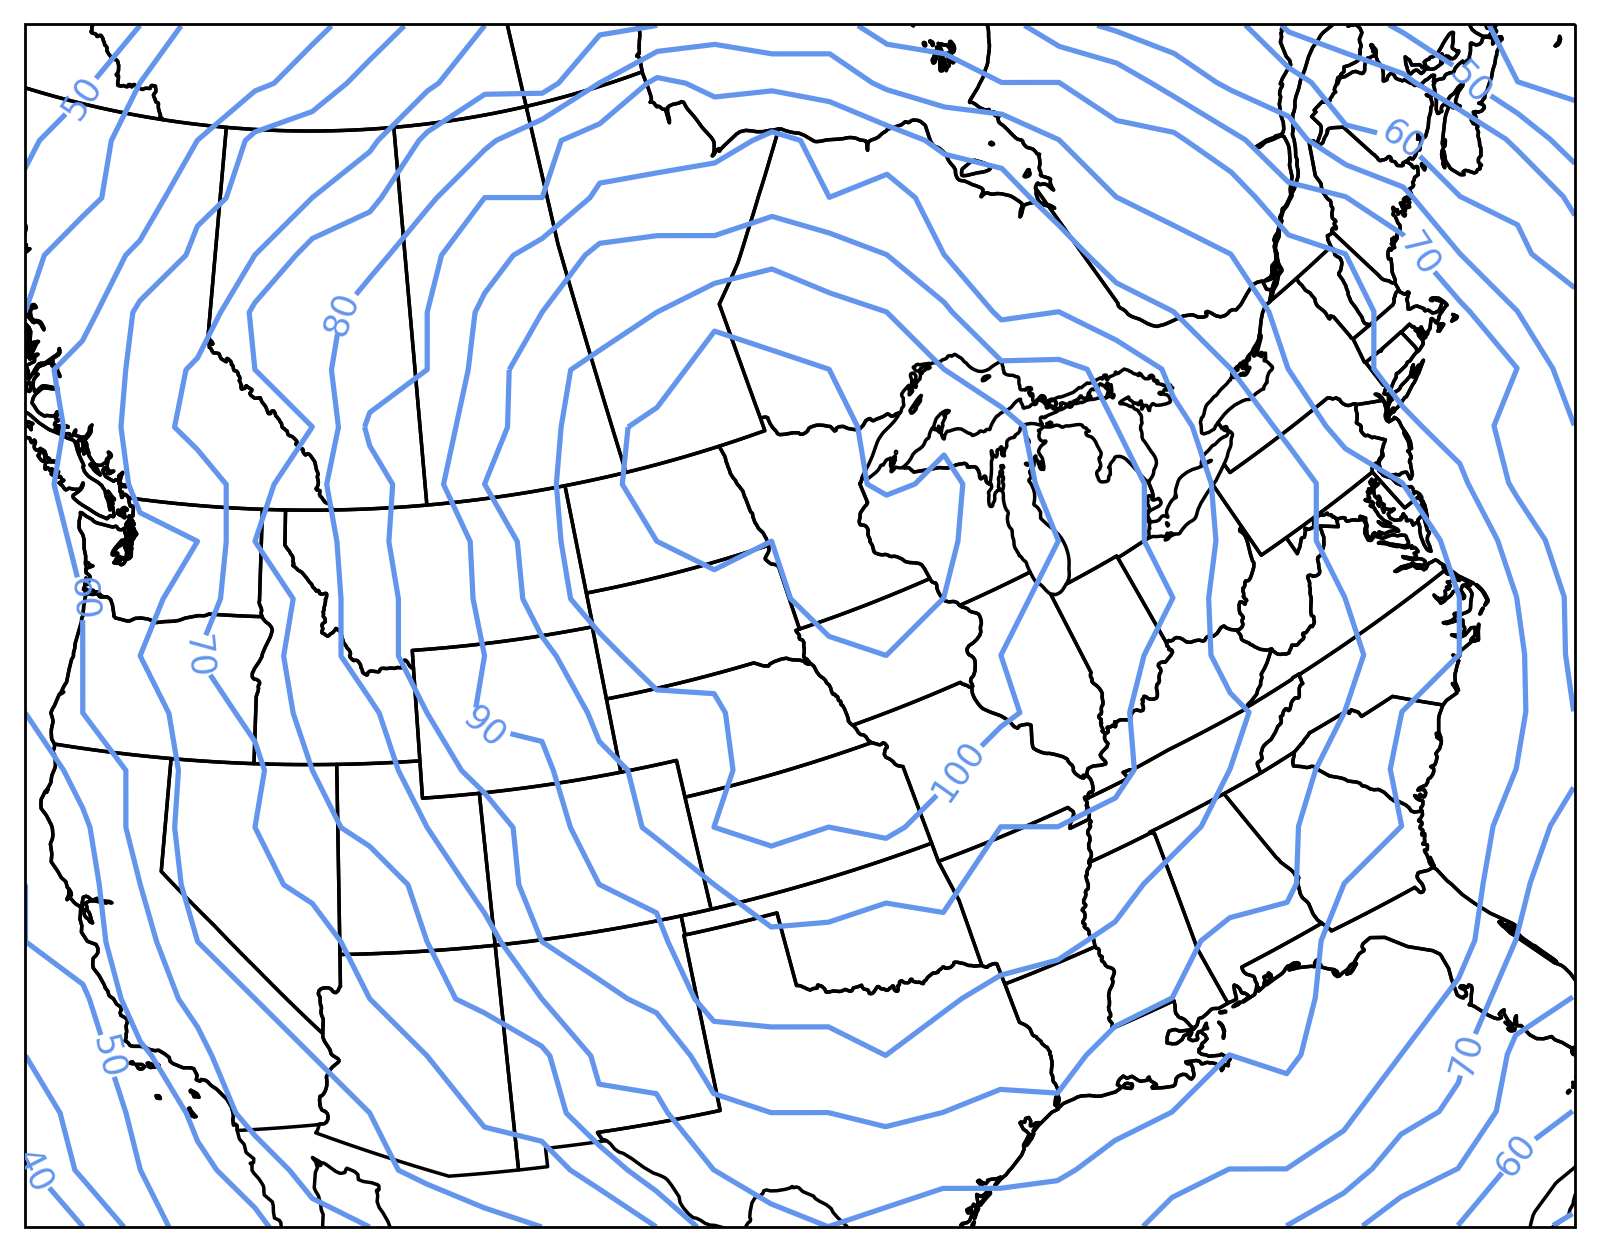

In [13]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,num_obs_twenty,colors='cornflowerblue',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))

plt.savefig('Sczepanski_ATSC528_HW1_numobs_ROI20.png', dpi = 250)
plt.show()

In [14]:
### Store the analyses in text files ###
np.savetxt('output_ROI_10cm.txt', ROI_ten)
np.savetxt('output_ROI_20cm.txt', ROI_twenty)

In [15]:
### Store the number of observations available for each grid point in text files ###
np.savetxt('num_obs_ROI_10cm.txt', num_obs_ten)
np.savetxt('num_obs_ROI_20cm.txt', num_obs_twenty)

In [16]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - Run your program using a radius of influence of 6 cm (do not need to show).  \n    Describe the results - do they look realistic?  If there are problems, what\n    do you think might be causing them?\n    \n\n4 - Suppose you ran this program with a small enough radius of influence that only one\n    observation was available for determining a polynomial fit at a grid point.  Should\n    you be able to perform the matrix inversion?  Why or why not?\n    \n\n'

In [17]:
# CODE FOR PROBLEM 3:
# Perform same analysis technique but for ROI = 6 cm


# Establish array to house analysis values for ROI = 6 cm:
ROI_six = np.full((len(y_j), len(x_i)), -999.9)

# Establish an array to save number of obs in ROI per analysis point:
num_obs_six = np.zeros((len(y_j), len(x_i)))

# Loop through gridded points:
for i in range(len(x_grid)):
    for j in range(len(x_grid[i])):
        
        # Establish ROI:
        ROI = 6 #cm
        
        # Calculate x_k and y_k, which are the difference between
        # x_obs, y_obs and the analysis point coordinates
        X_k = x_grid[i][j] - x_obs
        Y_k = y_grid[i][j] - y_obs
        
        # Calculate the magnitude of these differences:
        magnitude = (X_k**2 + Y_k**2)**(1/2)
        
        # Determine which indices fall within the ROI:
        indices = np.where(magnitude <= ROI)
        
        # Append the length of 'indices' to num_obs:
        num_obs_six[i][j] = len(indices[0])
        
        # Create arrays of all x_k, y_k, and heights (f_O) in ROI:
        x_k = X_k[indices[0]].values
        y_k = Y_k[indices[0]].values
        f_O = height[indices[0]].values
        
        # Establish an array of zeroes as a beginning for the 'R' matrix
        # and another array of zeroes for the 'O' vector. 
        # 'R' matrix is 6x6, and 'O' vector is 1x6:
        R_matrix = np.zeros((6,6))
        O_vector = np.zeros(6)
        
        # Loop through the length of x_k calculating the parts of
        # R_matrix and O_vector:
        for k in range(len(x_k)):
            
            ### Start with R_matrix:
            
            # First element is the number 1:
            one = 1
            
            # Second element is x_k:
            x = x_k[k]
            
            # Third element is y_k:
            y = y_k[k]
            
            # Fourth element is x_k squared:
            xx = x**2
            
            # Fifth element is y_k squared:
            yy = y**2
            
            # Sixth and final element is x_k times y_k:
            xy = x*y
            
            # Put these elements into an array that acts as the first
            # row of R_matrix:
            R_row = np.array([[one,
                               x,
                               y,
                               xx,
                               yy,
                               xy]])
            
            # Transpose R_row and multiply it by R_row to get the R_matrix;
            # append to R_matrix established previously:
            R_matrix += ((np.transpose(R_row))*R_row)
        
            ### Next, O_vector:
            
            # O_vector is the product of R_matrix and a coefficient
            # vector, which will later be called C_vector.
            
            # First element is f_O:
            f = f_O[k]
            
            # Second element is x_k times f_O:
            xf = x*f
            
            # Third element is y_k times f_O:
            yf = y*f
            
            # Fourth element is x_k squared times f_O:
            xxf = xx*f
            
            # Fifth element is y_k squared times f_O:
            yyf = yy*f
            
            # Sixth and final element is x_h times y_h times f_O:
            xyf = xy*f
            
            # Put these elements into an array that will be appended to 
            # O_vector:
            O_vector += (np.array([f,
                                   xf,
                                   yf,
                                   xxf,
                                   yyf,
                                   xyf]))
            
        # Get the mean values of R_matrix and O_vector by dividing each
        # by num_obs array. Also, immediately convert these arrays to
        # proper matrices:
        R_matrix = np.matrix(R_matrix / num_obs_six[i][j])
        
        O_vector = np.matrix(O_vector / num_obs_six[i][j])
        
        # Calculate the 'C' vector by multiplying inverse of R_matrix
        # by O_vector [ RC = O --> C = (R^-1)O ]:
        C_vector = np.linalg.inv(R_matrix)*np.transpose(O_vector)
        C_vector = np.linalg.inv(R_matrix)*O_vector.T
        
        
        # Finally, take the first value from C_vector (C_00) and append
        # to ROI_ten:
        ROI_six[i][j] = C_vector[0][0]

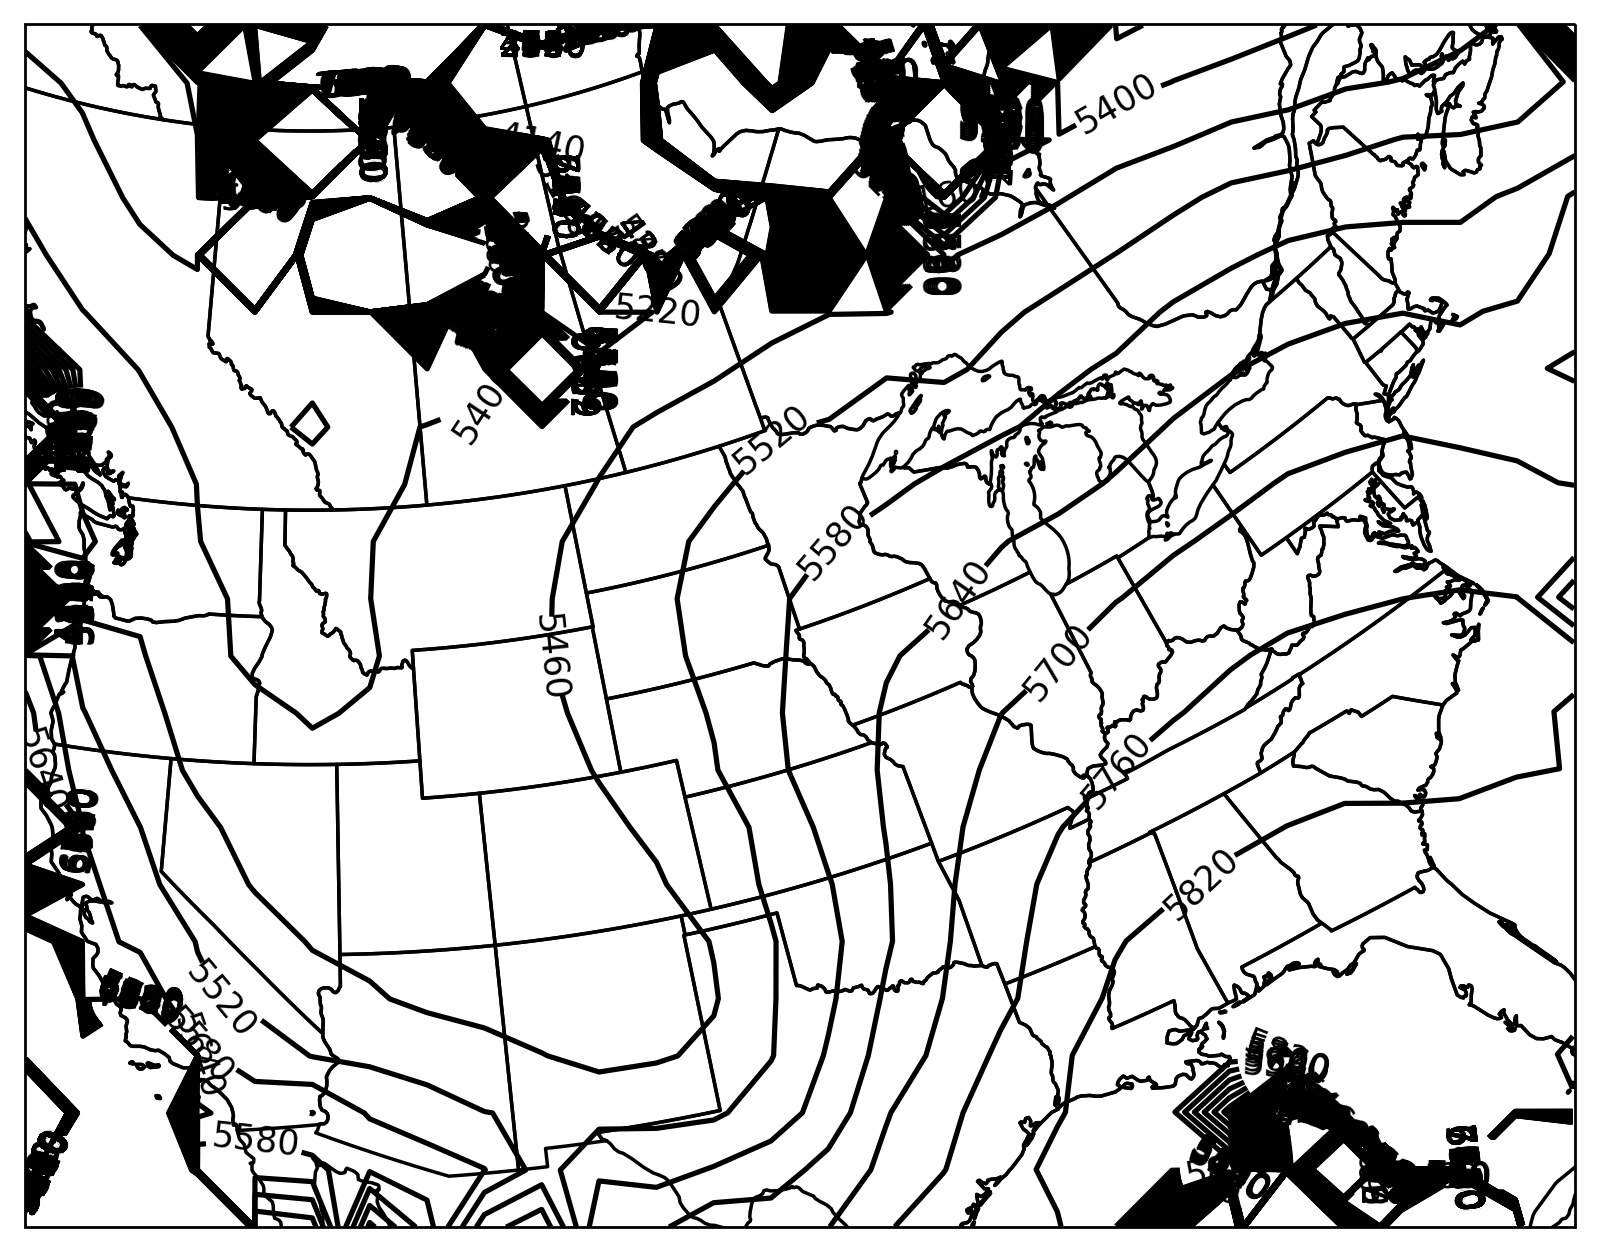

In [18]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,ROI_six,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

plt.savefig('Sczepanski_ATSC528_HW1_500hts_ROI6.png', dpi = 250)
plt.show()

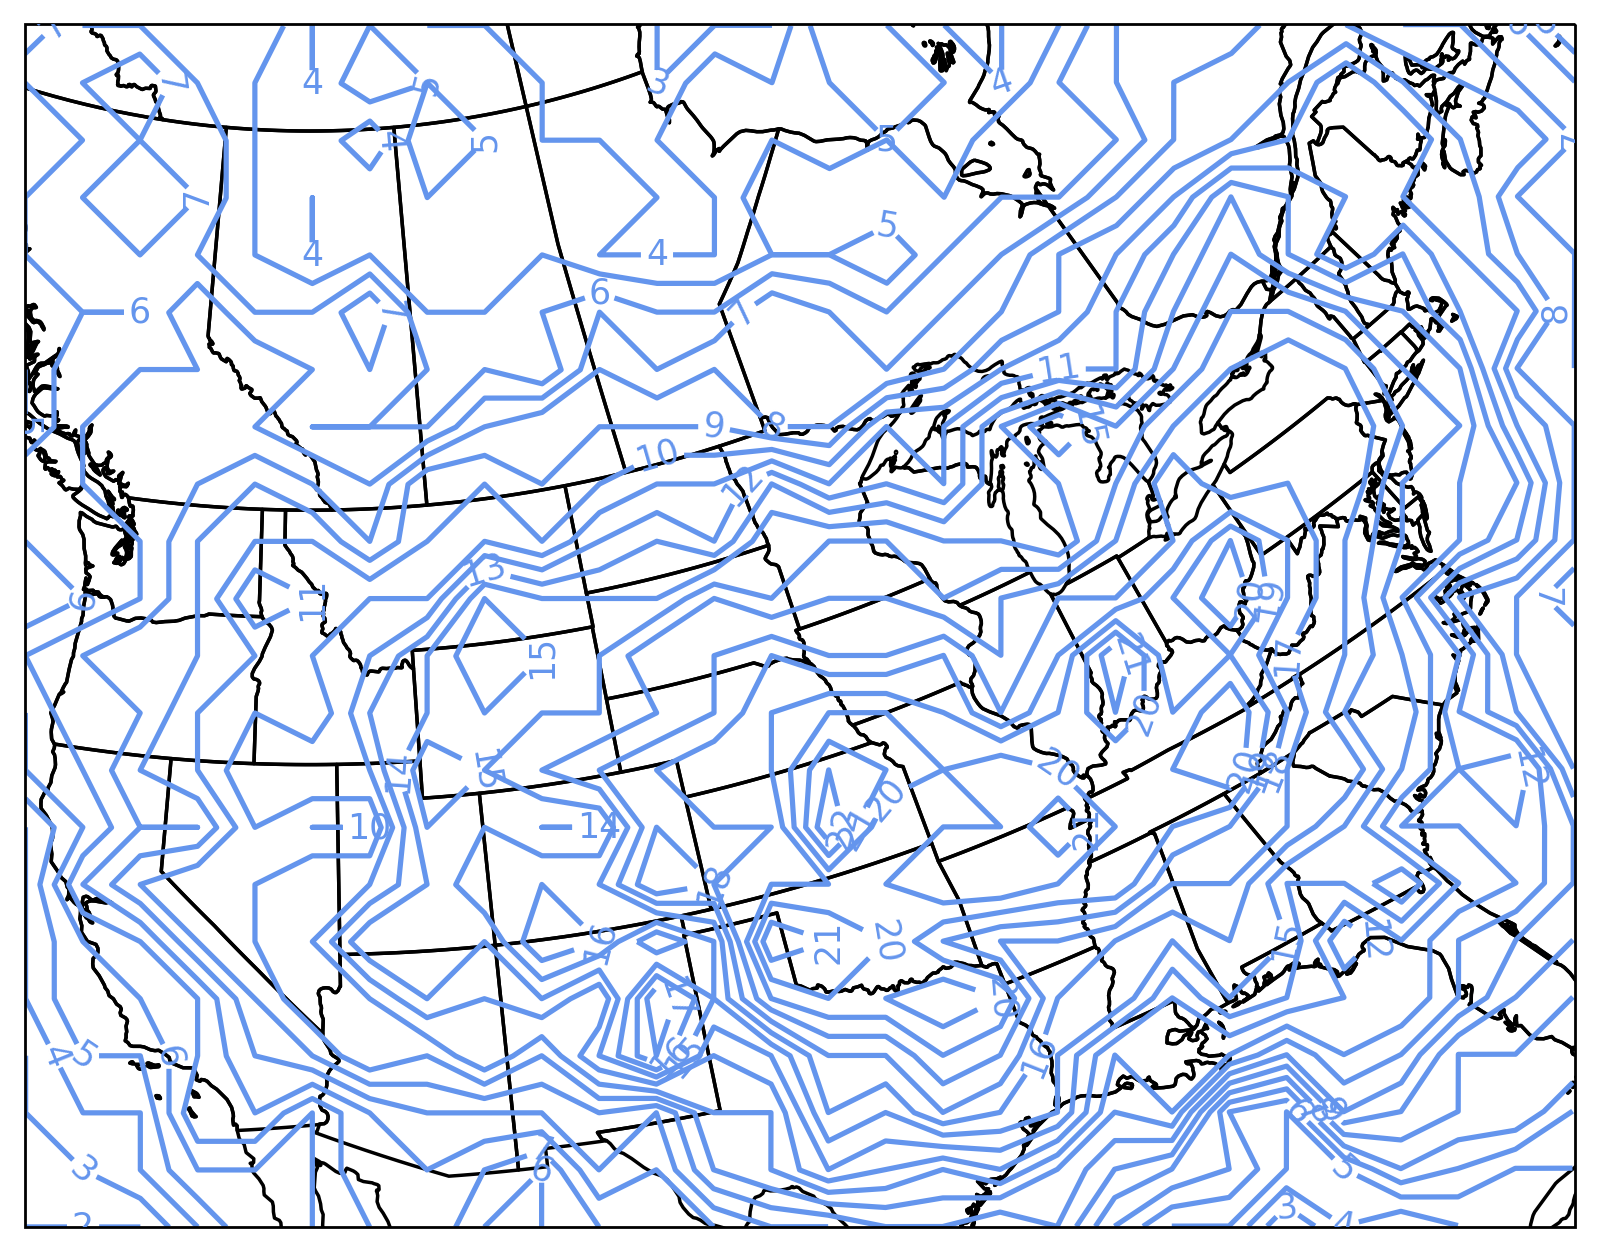

In [19]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=250)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(lam_grid,phi_grid,num_obs_six,colors='cornflowerblue',levels=np.arange(0,200,1),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,1))

plt.savefig('Sczepanski_ATSC528_HW1_numobs_ROI6.png', dpi = 250)
plt.show()